### Proyecto Individual Henry
**4_Sentiment_Analysis**  
Sentiment Analysis - Procesamiento del Lenguaje Natural  
**Autor: Bioing. Urteaga Facundo Nahuel**  
**Recursos: https://www.analyticsvidhya.com/blog/2021/06/vader-for-sentiment-analysis/**  
**Resumen:** Este script comprende las siguientes etapas:

1. **Carga de librerías**
2. **Carga de datos (archivo .parquet)**
3. **Pre-procesamiento de cada frase**
4. **Exploración de palabras mas frecuentes**
5. **Sentiment Analysis**

In [55]:
# 1. Carga de librerías

from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import numpy as np
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore') # Para evitar los molestos avisos.
import nltk
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('maxent_ne_chunker')
nltk.download('words')
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk import ne_chunk
import svgling
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Facundo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Facundo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Facundo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Facundo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Facundo\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Facundo\AppData\Roaming\nltk_data...
[nltk_data]   Package words is

In [39]:
# 2. Carga de datos

df_reviews = pd.read_parquet("df_reviews.parquet")
df_reviews.columns

Index(['user_id', 'item_id', 'recommend', 'review', 'op_pos', 'op_tot',
       'op_porc'],
      dtype='object')

In [40]:
# 3. Preprocesamiento de cada frase

# 3.1 Definición de stopwords

stopwords = nltk.corpus.stopwords.words('english') # Carga las stopwords
stopwords = [palabra for palabra in stopwords if 'not' not in palabra] # Elimina la palabra 'not' de las stopword

In [41]:
# Seleccionar nuevas stopwords y eliminarlas (Producto de una inspección posterior)

nuevas_sw = [
    "game", "play", "time", "realli", "make", "best", "love", "much", "want", "thing", "ever", "stori", "hour", "player", 
    "first", "gameplay", "kill", "graphic", "mani", "start", "charact", "jogo", "take", 
    "work", "weapon", "find", "level", "everi", "money", "life", "littl", "around", "world", "server", 
    "zombi", "review", "steam", "never", "use", "experi", "updat", "quit", "team", "person", "multiplay", "year", "build", "system", "nyan", 
    "control", "enemi", "actual", "someth", "keep", "base", "wait", "everyth", "go", "complet", "surviv", "howev", "must", "mode", "right", "develop", "combat", 
    "point", "tri", "muito", "commun", "hat", "overal", "chang", "item", "juego", "anyon", "shooter", "everyon", "seem", "sinc", "full", 
    "anoth", "call", "alway", "mod", "part", "stuff", "simul", "fight", "real", "releas", "shoot", "turn", "noth", "found", "gun", "mechan", "probabl", 
    "open", "alot", "super", "para", "style", "definit", "skill", "run", "sure", "mean", "issu", "minut"
]

In [42]:
stopwords = stopwords + nuevas_sw
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', '

In [43]:
# 3.2 Ciclo que realiza la supresión de caracteres que no son de interés, conversión a minúsculas, tokenización, eliminación de stopwords y stemmizacion

# Añadir la columna "review_token" al DataFrame si no existe
if "review_token" not in df_reviews:
    df_reviews["review_token"] = ""

lemmatizer = WordNetLemmatizer()

for index, frase in df_reviews["review"].items():
    # Normalización
    frase = re.sub("[^a-zA-Zñíá]"," ",str(frase)).lower()
    frase = nltk.tokenize.word_tokenize(frase)
    frase = [palabra for palabra in frase if len(palabra)>3]
    frase = [word for word in frase if word not in stopwords]

    # Aplicamos la funcion para buscar la raiz de las palabras
    #frase = [stemmer.stem(palabra) for palabra in frase]
    frase = [lemmatizer.lemmatize(palabra) for palabra in frase]
    frase = [word for word in frase if word not in stopwords] # Aplicamos nuevamente las stopwords

    df_reviews.at[index, "review_token"] = frase
    # Stemmizacion


In [44]:
# 4. Exploración de palabras mas frecuentes

# Concatenar todos los strings en una sola cadena separada por espacios
texto_completo = ' '.join(df_reviews['review_token'].sum())
#7 minutos

In [45]:
print(texto_completo[0:100])

simple great replayability opinion zombie horde better left dead plus global leveling earth zombie s


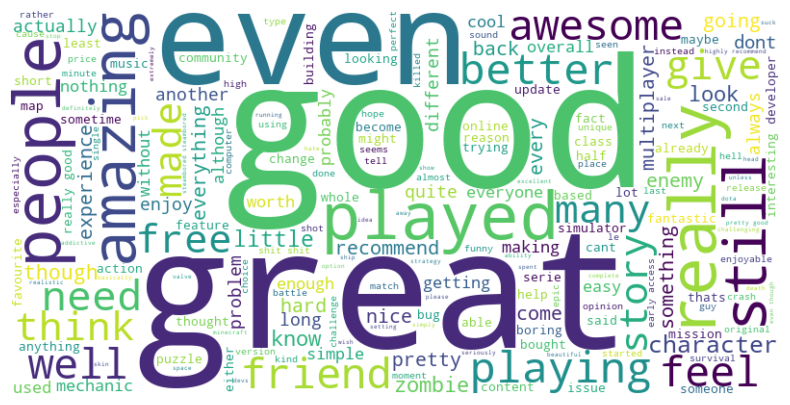

In [46]:
# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_completo)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [47]:
# Dividir el string en palabras individuales
palabras = texto_completo.split()

In [48]:
freq_palabras = nltk.FreqDist(palabras) # Calcula la frecuencia de cada palabra
freq_palabras

FreqDist({'like': 11059, 'good': 10764, 'great': 9096, 'really': 6763, 'would': 6697, 'even': 4559, 'played': 4516, 'people': 4080, 'playing': 4049, 'amazing': 3927, ...})

In [49]:
df_freq_palabras = pd.DataFrame(list(freq_palabras.items()), columns = ["Word","Frequency"]) # Convierte el objeto FreqDist en un DataFrame de pandas para poder graficarlo con seaborn
df_freq_palabras.sort_values('Frequency',ascending=False, inplace = True) # Ordena el DataFrame por frecuencia
df_freq_palabras.reset_index(drop = True, inplace=True) # Resetea el índice del DataFrame
df_freq_palabras.head()

,Word,Frequency
0,like,11059
1,good,10764
2,great,9096
3,really,6763
4,would,6697


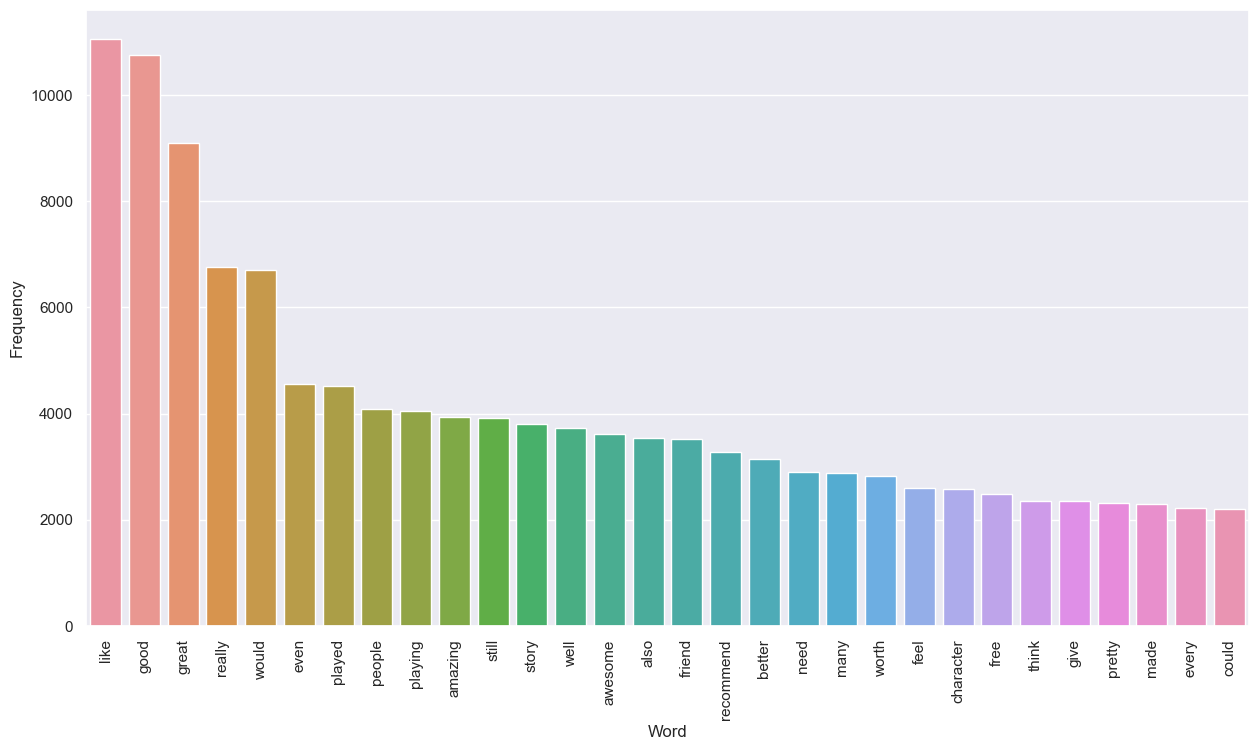

In [50]:
plt.figure(figsize = (15,8)) # Configura el tamaño de la figura
plot = sns.barplot(x  = df_freq_palabras.iloc[:30].Word, y = df_freq_palabras.iloc[:30].Frequency) # Grafica las 30 palabras más frecuentes 
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

In [ ]:
for token in df_reviews["review_token"].iloc[12]:
    print(nltk.pos_tag([token]))


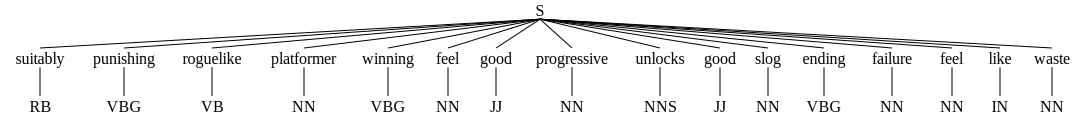

In [53]:

#token = nltk.word_tokenize(df_reviews["review_token"].iloc[12])
tags = nltk.pos_tag(df_reviews["review_token"].iloc[6])
chunk = ne_chunk(tags)
chunk

In [60]:
# 5. Sentiment Analysis con VADER

# Función didáctica

def sentiment_scores(sentence):

    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    print(sentence)
    print("La puntuación de sentimientos general es:: ", sentiment_dict)
    print("La oración se calificó como un ", sentiment_dict['neg']*100, "% Negativa")
    print("La oración se calificó como un ", sentiment_dict['neu']*100, "% Neutral")
    print("La oración se calificó como un ", sentiment_dict['pos']*100, "% Positiva")
    print("La oración finalmente fue calificada como", end = " ")
    # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0.05 :
        print("Positiva")
    elif sentiment_dict['compound'] <= - 0.05 :
        print("Negativa")
    else :
        print("Neutral")

In [57]:
# Función final para el procesamiento

def sentiment_decision(sentence):

    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    # Decide directamente si la frase es positiva (2), neutral (1) o negativa (0)
    if sentiment_dict['compound'] >= 0.05 :
        return 2
    elif sentiment_dict['compound'] <= - 0.05 :
        return 0
    else :
        return 1

In [58]:
# Vuelvo a formar un solo string por celda para ingresarlo en el analisis

def join_tokens(token_list):
    return ' '.join(token_list)

# Aplica la función join_tokens a cada elemento de la columna "review_token"
df_reviews["review_text"] = df_reviews["review_token"].apply(join_tokens)

In [62]:
# Control del funcionamiento del análisis

sentiment_scores(df_reviews["review_text"].iloc[12])

sequence improved walking dead also includes puzzle solving episode walking dead also get even better read fable comic book without doubt good music also superb scenario well
La puntuación de sentimientos general es::  {'neg': 0.186, 'neu': 0.39, 'pos': 0.424, 'compound': 0.8406}
La oración se calificó como un  18.6 % Negativa
La oración se calificó como un  39.0 % Neutral
La oración se calificó como un  42.4 % Positiva
La oración finalmente fue calificada como Positiva


In [63]:
# Ejecuto el análisis en todas las reseñas

df_reviews["sentiment_analysis"] = pd.Series()

for index, frase in df_reviews["review_text"].items():

    df_reviews["sentiment_analysis"].iloc[index] = sentiment_decision(df_reviews["review_text"].iloc[index])

    # 32 minutos

In [64]:
df_reviews["sentiment_analysis"].value_counts()

sentiment_analysis
2    32566
1    18296
0     8443
Name: count, dtype: int64

In [65]:
df_reviews["recommend"].value_counts()

recommend
True     52473
False     6832
Name: count, dtype: int64

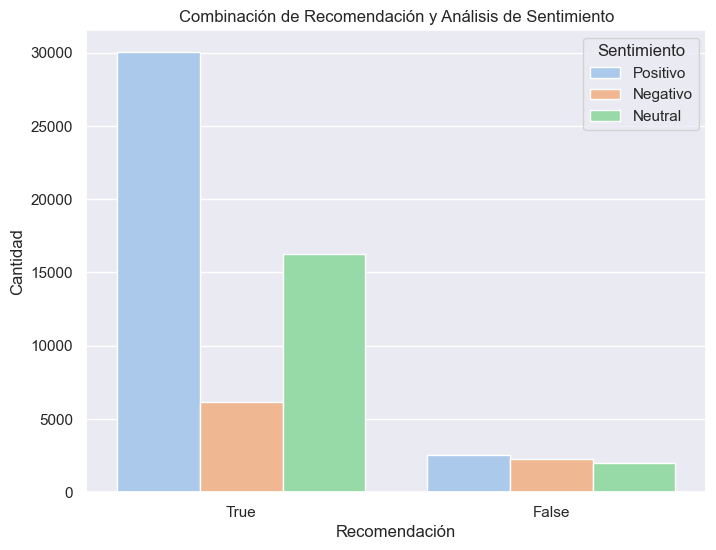

In [66]:
# Gráfico que muestra la relación entre recommend y sentiment analysis

sentiment_mapping = {2: "Positivo", 1: "Neutral", 0: "Negativo"}
df_reviews["sentiment_label"] = df_reviews["sentiment_analysis"].map(sentiment_mapping)

# Crear un gráfico de torta con Seaborn
plt.figure(figsize=(8, 6))
sns.set_palette("pastel")
sns.countplot(data=df_reviews, x="recommend", hue="sentiment_label", order=[True, False])
plt.title("Combinación de Recomendación y Análisis de Sentimiento")
plt.xlabel("Recomendación")
plt.ylabel("Cantidad")
plt.legend(title="Sentimiento")
plt.show()

In [67]:
# 6. Exportar el df final a parquet

df_reviews_con_sa = df_reviews[['user_id', 'item_id','recommend','op_pos','op_tot','op_porc','sentiment_analysis']]
df_reviews_con_sa.to_parquet('df_reviews_con_sa.parquet')

### FIN